In [1]:
#for local
import sys
molgen_path = "../"
if molgen_path not in sys.path:
    sys.path.insert(0, molgen_path)

In [2]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path
from node import MolSentenceNode #change after Filter implementation
from generator import MCTS

c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
config_path = "config/mcts_helm.yaml"
with open(molgen_path + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(molgen_path + lang_path)
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=molgen_path + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

Search is started.
0- time: 0.00, count_rollouts: 1, reward: -0.26814403716093577, mol: PEPTIDE1{F.S.E.L.A.R}$$$$
1- time: 0.15, count_rollouts: 3, reward: -0.6528995189182369, mol: PEPTIDE1{[ac].F.Q.S.K.A.N.V.F.V.D.G.Y.F.E.R.I.R.A.K.L.[am]}$$$$
2- time: 0.27, count_rollouts: 4, reward: -0.336493490307569, mol: PEPTIDE1{R.P.K.P.Q.Q.F.F.G.[dL].M.[am]}$$$$
3- time: 0.34, count_rollouts: 5, reward: -0.412150485049632, mol: PEPTIDE1{Y.G.G.[dF].L.R.R.I.R.P.K.[am]}$$$$
4- time: 0.40, count_rollouts: 6, reward: -0.3282271055881201, mol: PEPTIDE1{G.A.L.G.A.A.[am]}$$$$
5- time: 0.45, count_rollouts: 7, reward: -0.6754539538718263, mol: PEPTIDE1{F.G.G.F.T.G.A.R.K.S.A.R.K}$$$$
6- time: 0.51, count_rollouts: 8, reward: -0.19068989534026384, mol: PEPTIDE1{A.A.A.L.K.A.A.W.L.R}$$$$
7- time: 0.55, count_rollouts: 9, reward: -0.7180389904085517, mol: PEPTIDE1{T.P.Q.R.[dM].R.R.R.K.K.R.M}$$$$
8- time: 0.62, count_rollouts: 10, reward: 0.07296012498270124, mol: PEPTIDE1{K.W.L.L.L.H.G.L.A.G.L.N.W.L.L.H.A.L

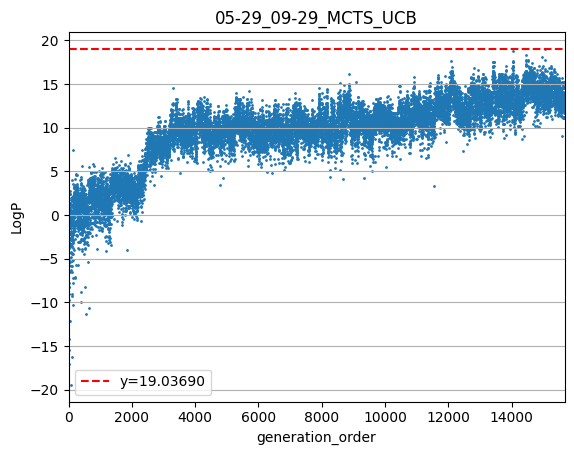

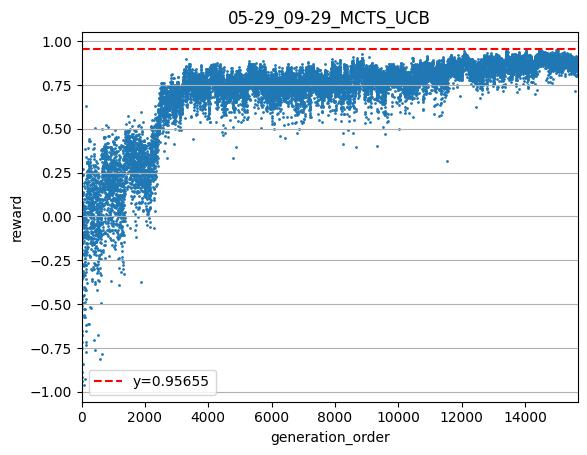

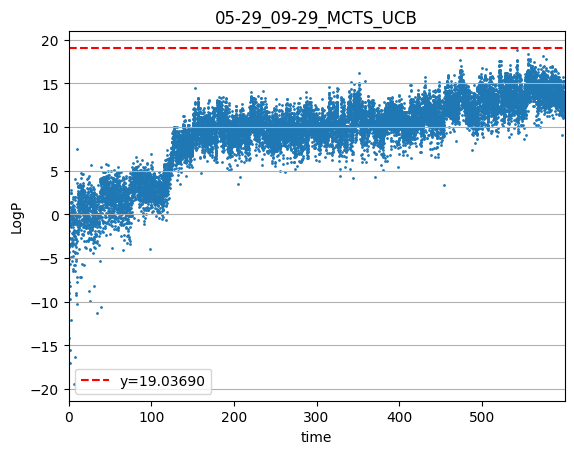

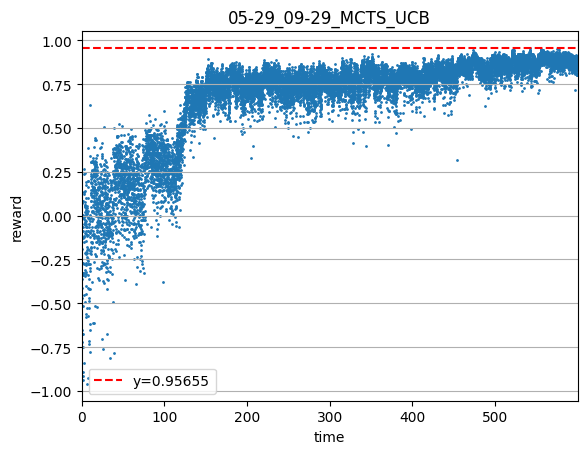

Search is completed.


In [9]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)